In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.
import matplotlib
plt.style.use('seaborn-whitegrid')
!pip install statsmodels
!pip install pmdarima

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

%matplotlib inline

import itertools

<ipython-input-1-250e88fbb2c1>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.4 MB/s eta 0:00:00


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import joblib
path = '/content/drive/MyDrive/KT_aivle/미니프로젝트6차/장애인콜택시대기시간/'
df = joblib.load(path+'data1.pkl')
data = df.drop_duplicates(subset=['Date'], keep='first')
df.head()

,Date,N_of_Cars,N_of_apply,N_of_rides,Waiting_T,Price,Distance,year,month,week,...,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),day_of_week,Roll_Waiting_T,holiday,target,Roll_N_of_rides
0,2015-01-01,213,1023,924,23.2,2427,10764,2015,1,1,...,-9.8,0.0,52.0,33.0,9.79,3,23.200,1.0,17.2,924.00
1,2015-01-02,420,3158,2839,17.2,2216,8611,2015,1,1,...,-8.9,0.0,63.0,28.0,9.07,4,20.200,0.0,26.2,1881.50
2,2015-01-03,209,1648,1514,26.2,2377,10198,2015,1,1,...,-9.2,0.0,73.0,37.0,8.66,5,22.200,0.0,24.5,1759.00
3,2015-01-04,196,1646,1526,24.5,2431,10955,2015,1,1,...,0.2,0.0,89.0,58.0,5.32,6,22.775,0.0,26.2,1700.75
4,2015-01-05,421,4250,3730,26.2,2214,8663,2015,1,2,...,-0.9,0.0,95.0,52.0,6.48,0,23.460,0.0,23.6,2106.60


In [4]:
df = df[['Date','target']]

In [5]:
df.index = df['Date']
df = df.drop('Date', axis=1)
df

,target
Date,
2015-01-01,17.2
2015-01-02,26.2
2015-01-03,24.5
2015-01-04,26.2
2015-01-05,23.6
...,...
2022-12-27,44.8
2022-12-28,52.5
2022-12-29,38.3


In [6]:
df = df.dropna()

# raw data 확인

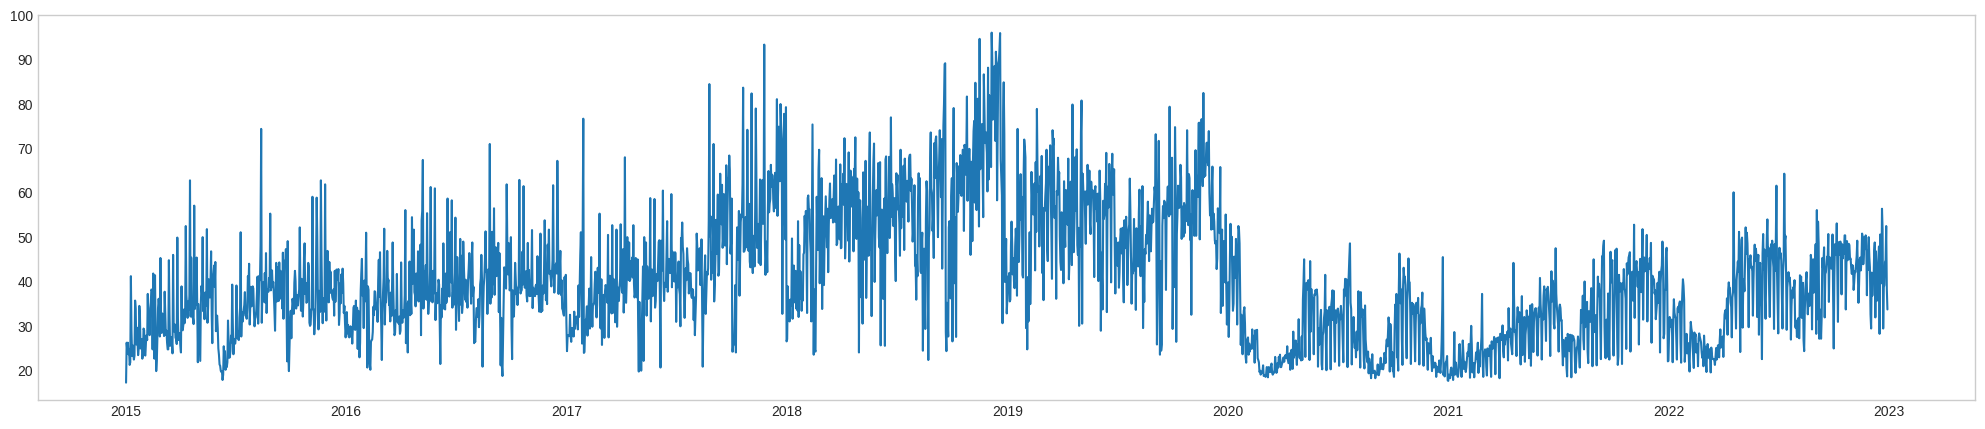

In [7]:
plt.figure(figsize=(25,5))
plt.plot(df)
plt.grid()

# seasonal decomposition

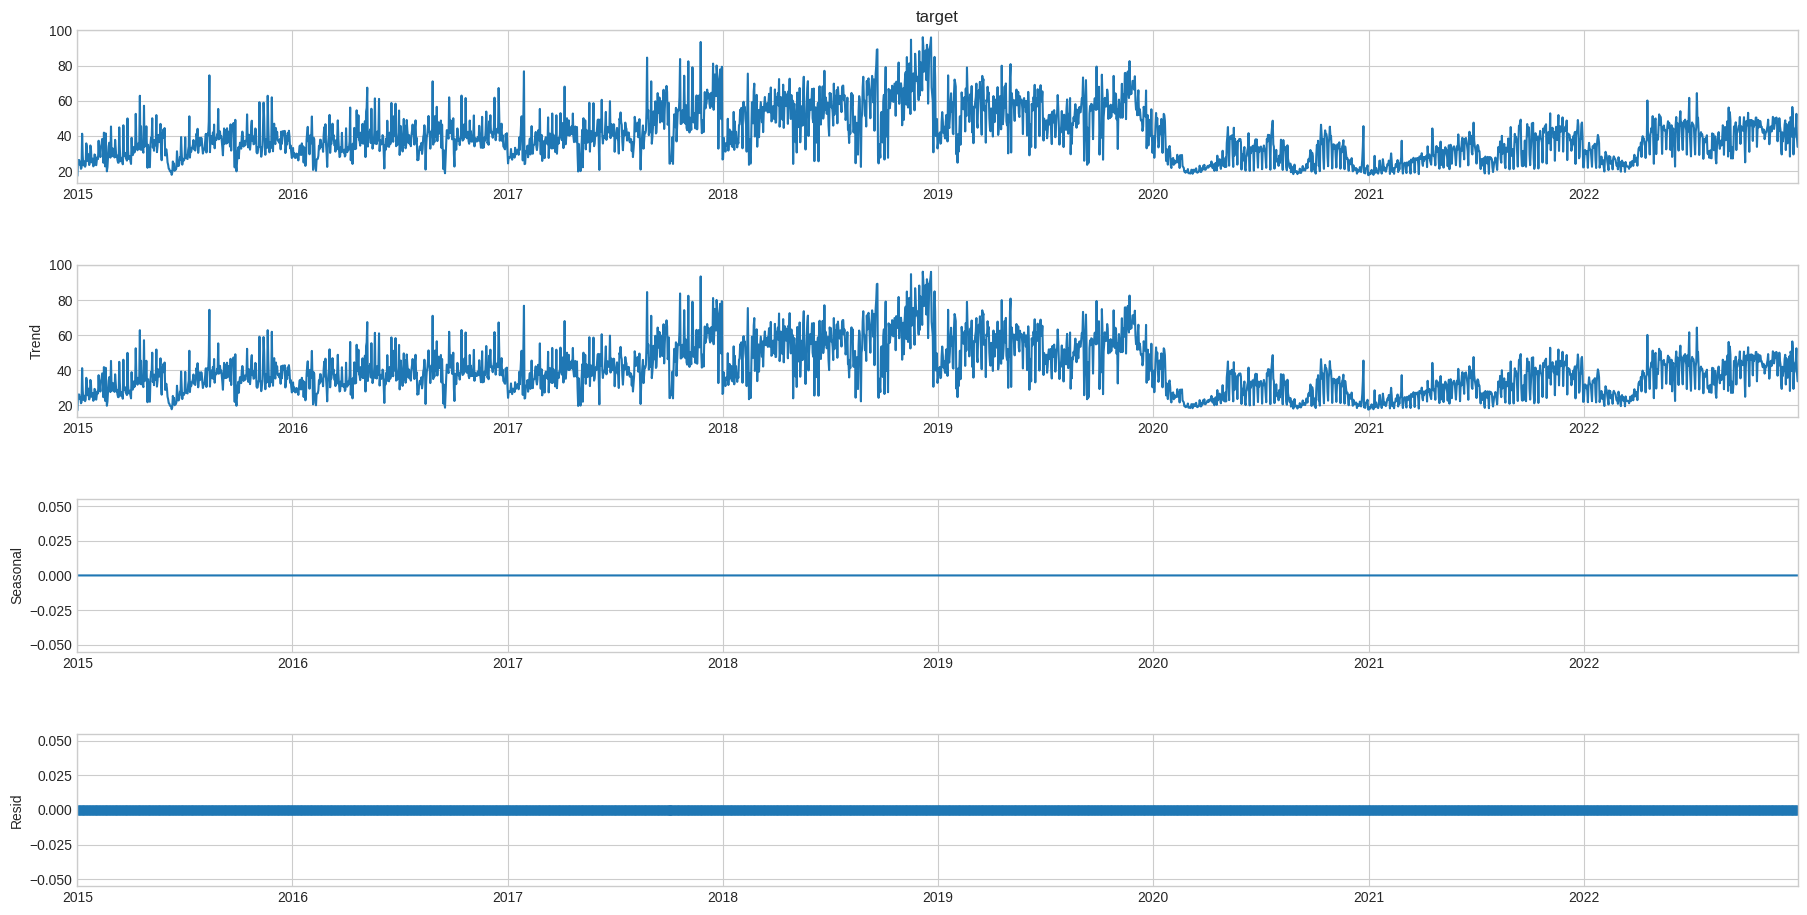

In [8]:
decomposition = sm.tsa.seasonal_decompose(df['target'], model = 'additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(20,10)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, shuffle=False)
train.shape, test.shape

((2339, 1), (585, 1))

# ACF, PACF

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


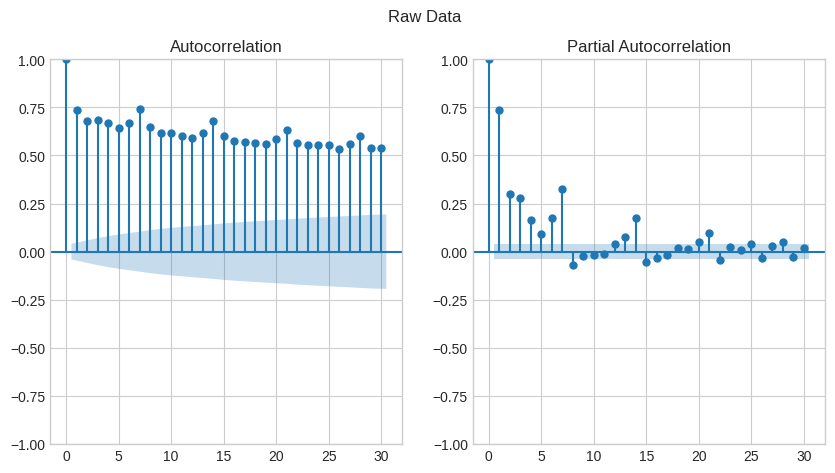

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=30, ax=ax[0]) # auto correlation ft
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=30, ax=ax[1]); # partial auto correlation ft

* auto correlation의 경우 파도 모양으로 구성되어 있다면 대표적인 Trend가 있어 non-stationary 한 데이터에서 발생하는 그런 acf plot으로 볼 수 있다. 

==> 위에서 rawdata, seasonal_decomposition, acf/pacf 를 확인해 보았을 때 대략적으로 non-stationary하다고 볼 수 있다.

==> 이 non-stationary한 것을 stationary하게 보정하기 위해 차분을 사용한다.

# differencing

In [11]:
diff_train = train.diff()
diff_test = test.diff()

In [12]:
diff_train = diff_train.dropna()
diff_test = diff_test.dropna()

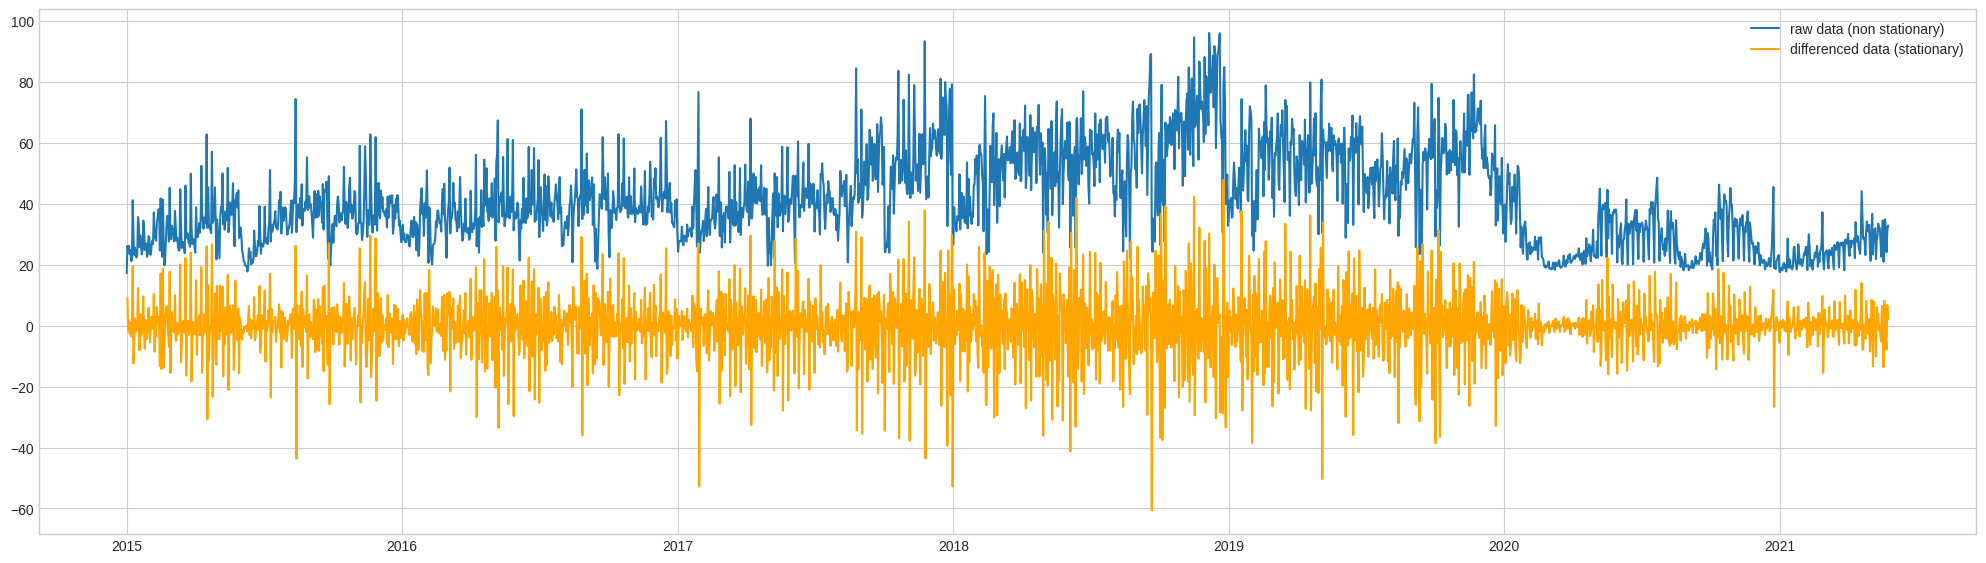

In [13]:
plt.figure(figsize=(25,15))
plt.subplot(2, 1, 1)
plt.plot(train['target'])
plt.subplot(2, 1, 1)
plt.plot(diff_train['target'], 'orange')
plt.legend(['raw data (non stationary)', 'differenced data (stationary)'])
plt.show()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


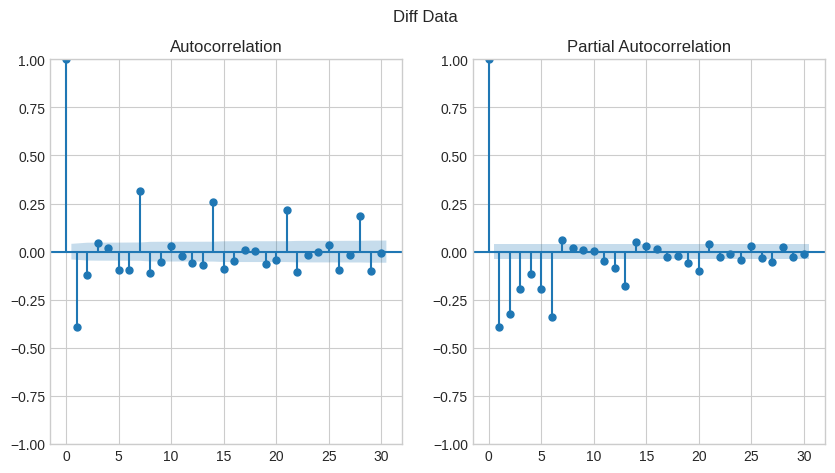

In [14]:
# 1차 차분한 데이터를 대상으로 ACF와 PACF 확인

fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Diff Data')
sm.graphics.tsa.plot_acf(diff_train.values.squeeze(), lags=30, ax=ax[0]) # auto correlation ft - sin함수와 같이 형태가 바뀌고 어느 정도 높이가 감소하였다. 
sm.graphics.tsa.plot_pacf(diff_train.values.squeeze(), lags=30, ax=ax[1]); # partial auto correlation ft - 

# 이제 graphical method를 통해 어떤 모델을 이용할 지 선정해야 한다.

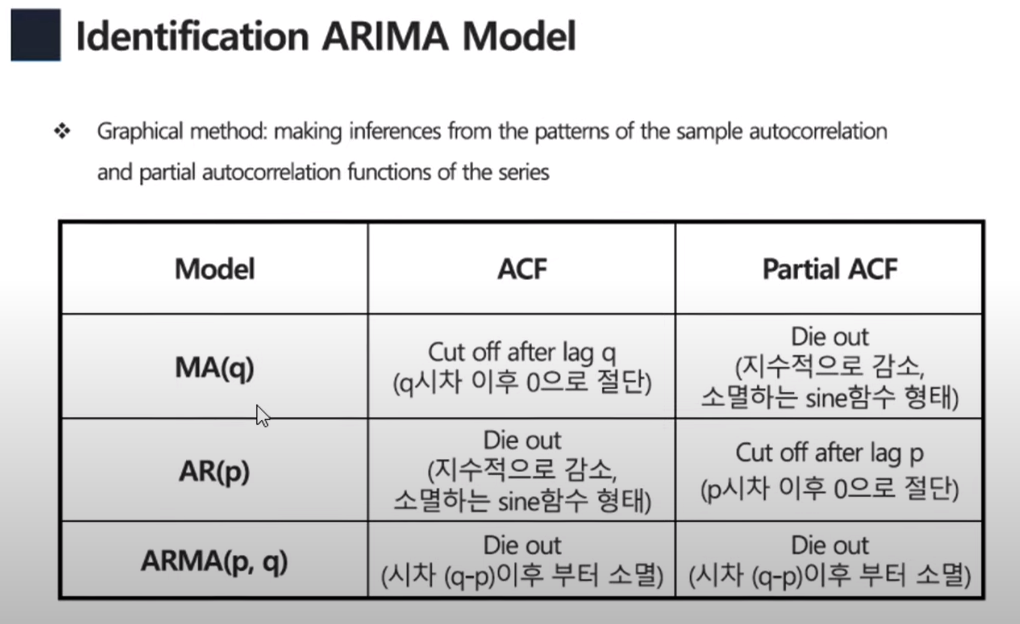

## 이제는 ARIMA모델을 구축
* AR모델과 같은 형태를 띄기에 p를 설정해 준다.
  * p설정을 위해 딱 감소하는 부분을 찾아야 하는데 여기서는 1로 선정을 하고 AR이 1이고 차분이 1인 ARIMA(p,d,q)모델을 구축 

   => ARIMA(order=(1,1,0))

In [15]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train.values, order=(7,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2339
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -8316.713
Date:                Thu, 20 Apr 2023   AIC                          16649.426
Time:                        00:56:31   BIC                          16695.482
Sample:                             0   HQIC                         16666.203
                               - 2339                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6708      0.015    -44.921      0.000      -0.700      -0.642
ar.L2         -0.5784      0.018    -32.398      0.000      -0.613      -0.543
ar.L3         -0.4453      0.018    -24.096      0.0

* Diagnsis Check - ARIMA

In [16]:
p = range(0,8)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))

aic = []

for i in pdq:
  model = ARIMA(train.values, order=(i))
  model_fit = model.fit()
  print(f'ARIMA: {i} >> AIC : {round(model_fit.aic,2)}')
  aic.append(round(model_fit.aic, 2))

ARIMA: (0, 1, 0) >> AIC : 17784.64
ARIMA: (0, 1, 1) >> AIC : 16885.14
ARIMA: (0, 1, 2) >> AIC : 16844.25
ARIMA: (1, 1, 0) >> AIC : 17398.5
ARIMA: (1, 1, 1) >> AIC : 16847.81


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA: (1, 1, 2) >> AIC : 16844.33
ARIMA: (2, 1, 0) >> AIC : 17138.67
ARIMA: (2, 1, 1) >> AIC : 16846.09
ARIMA: (2, 1, 2) >> AIC : 16838.95
ARIMA: (3, 1, 0) >> AIC : 17051.89
ARIMA: (3, 1, 1) >> AIC : 16845.26
ARIMA: (3, 1, 2) >> AIC : 16840.94
ARIMA: (4, 1, 0) >> AIC : 17023.24
ARIMA: (4, 1, 1) >> AIC : 16846.58
ARIMA: (4, 1, 2) >> AIC : 16842.92
ARIMA: (5, 1, 0) >> AIC : 16936.55
ARIMA: (5, 1, 1) >> AIC : 16807.24
ARIMA: (5, 1, 2) >> AIC : 16721.29
ARIMA: (6, 1, 0) >> AIC : 16655.55
ARIMA: (6, 1, 1) >> AIC : 16650.27
ARIMA: (6, 1, 2) >> AIC : 16651.13
ARIMA: (7, 1, 0) >> AIC : 16649.43
ARIMA: (7, 1, 1) >> AIC : 16650.77
ARIMA: (7, 1, 2) >> AIC : 16620.57


In [17]:
optimal = [(pdq[i], j) for i,j in enumerate(aic) if j==min(aic)]
optimal

[((7, 1, 2), 16620.57)]

In [18]:
model_opt = ARIMA(train.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()

print(model_opt_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2339
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -8300.287
Date:                Thu, 20 Apr 2023   AIC                          16620.574
Time:                        00:56:45   BIC                          16678.144
Sample:                             0   HQIC                         16641.546
                               - 2339                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0892      0.056      1.592      0.111      -0.021       0.199
ar.L2          0.1197      0.023      5.190      0.000       0.075       0.165
ar.L3          0.1187      0.018      6.475      0.0

* use Model to Forcast - ARIMA

In [19]:
from sklearn.metrics import r2_score

prediction = model_opt_fit.forecast(len(test))
predicted_value = prediction
predicted_ub = prediction[1]
predicted_lb = prediction[2]
predict_index = list(test.index)
r2 = r2_score(test.values, predicted_value)

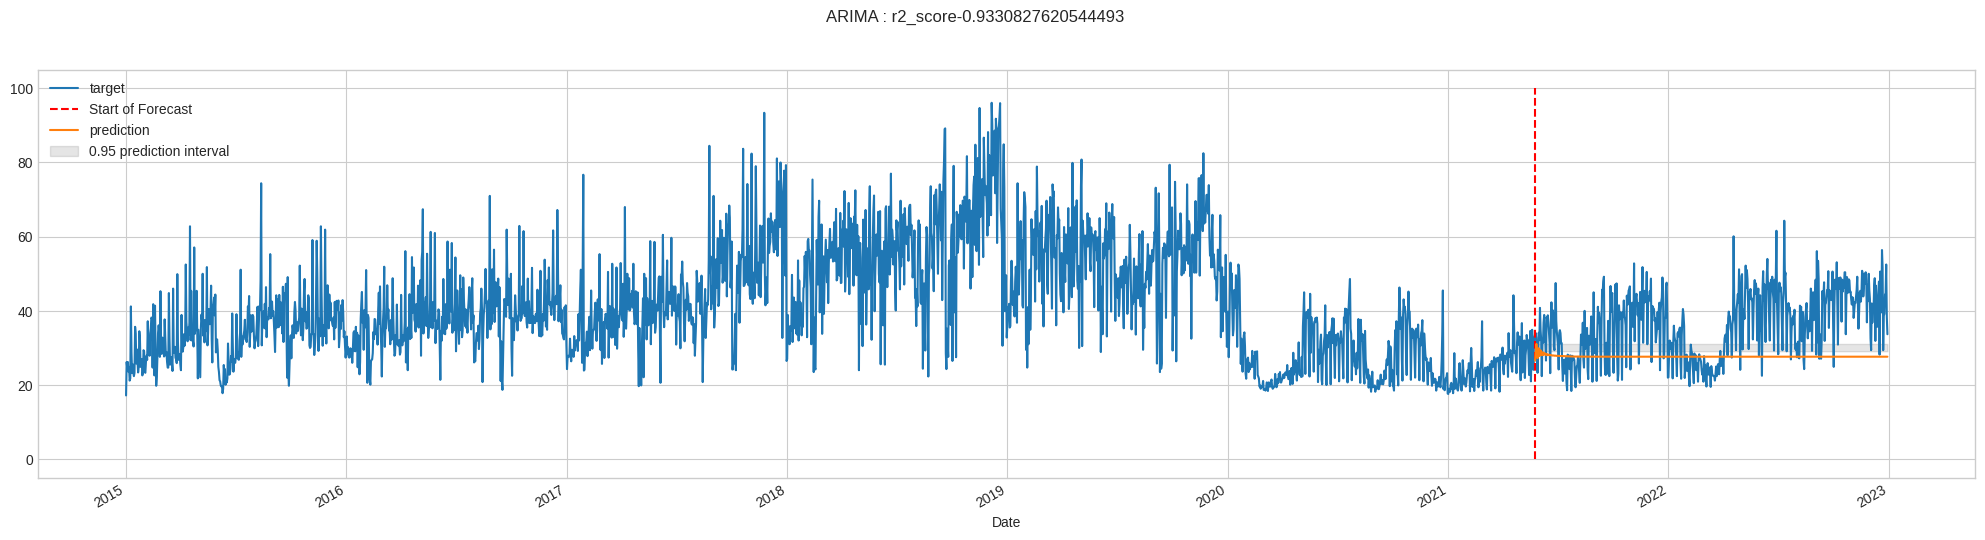

In [20]:
fig, ax = plt.subplots(figsize=(25, 6))
df.plot(ax=ax)
ax.vlines('2021-05-25', 0, 100, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predicted_value, label = 'prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA : r2_score{r2}')
plt.show()

* Diagnsis Check - SARIMA

In [21]:
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2],  12) for x in pdq]

aic = []
params = []
for i in pdq:
  for j in seasonal_pdq:
    try:
      model = SARIMAX(train.values, order=(i), seasonal_order=(j))
      model_fit = model.fit()
      print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic,2)}')
      aic.append(round(model_fit.aic, 2))
      params.append((i,j))
    except:
      continue

SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : 19444.88
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : 17754.62
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : 17747.83
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : 18692.2
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : 17747.93
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : 17758.23
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : 18420.24
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : 17749.84
SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : 17746.43
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : 18646.68
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : 16865.64
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : 16840.53
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : 17889.19
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : 16842.89
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : 16869.48
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : 17512.04
SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : 16838.78


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC : 16836.32
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : 18459.98
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : 16823.89
SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : 16807.94
SARIMA: (0, 1, 2)(1, 1, 0, 12) >> AIC : 17829.64
SARIMA: (0, 1, 2)(1, 1, 1, 12) >> AIC : 16809.46
SARIMA: (0, 1, 2)(1, 1, 2, 12) >> AIC : 16827.65
SARIMA: (0, 1, 2)(2, 1, 0, 12) >> AIC : 17484.71
SARIMA: (0, 1, 2)(2, 1, 1, 12) >> AIC : 16806.75


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (0, 1, 2)(2, 1, 2, 12) >> AIC : 16803.97
SARIMA: (1, 1, 0)(0, 1, 0, 12) >> AIC : 19183.0
SARIMA: (1, 1, 0)(0, 1, 1, 12) >> AIC : 17373.45
SARIMA: (1, 1, 0)(0, 1, 2, 12) >> AIC : 17340.05
SARIMA: (1, 1, 0)(1, 1, 0, 12) >> AIC : 18333.57
SARIMA: (1, 1, 0)(1, 1, 1, 12) >> AIC : 17339.9
SARIMA: (1, 1, 0)(1, 1, 2, 12) >> AIC : 17376.81
SARIMA: (1, 1, 0)(2, 1, 0, 12) >> AIC : 17985.32
SARIMA: (1, 1, 0)(2, 1, 1, 12) >> AIC : 17341.75


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 0)(2, 1, 2, 12) >> AIC : 17336.05
SARIMA: (1, 1, 1)(0, 1, 0, 12) >> AIC : 18470.97
SARIMA: (1, 1, 1)(0, 1, 1, 12) >> AIC : 16827.52
SARIMA: (1, 1, 1)(0, 1, 2, 12) >> AIC : 16809.92
SARIMA: (1, 1, 1)(1, 1, 0, 12) >> AIC : 17829.0
SARIMA: (1, 1, 1)(1, 1, 1, 12) >> AIC : 16811.45
SARIMA: (1, 1, 1)(1, 1, 2, 12) >> AIC : 16831.39
SARIMA: (1, 1, 1)(2, 1, 0, 12) >> AIC : 17485.17
SARIMA: (1, 1, 1)(2, 1, 1, 12) >> AIC : 16809.15


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 1)(2, 1, 2, 12) >> AIC : 16806.03
SARIMA: (1, 1, 2)(0, 1, 0, 12) >> AIC : 18463.61


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)(0, 1, 1, 12) >> AIC : 16824.2


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)(0, 1, 2, 12) >> AIC : 16809.29
SARIMA: (1, 1, 2)(1, 1, 0, 12) >> AIC : 17791.59


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)(1, 1, 1, 12) >> AIC : 16810.86


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)(1, 1, 2, 12) >> AIC : 16827.86


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)(2, 1, 0, 12) >> AIC : 17448.85


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)(2, 1, 1, 12) >> AIC : 16807.36


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (1, 1, 2)(2, 1, 2, 12) >> AIC : 16805.22
SARIMA: (2, 1, 0)(0, 1, 0, 12) >> AIC : 18776.02
SARIMA: (2, 1, 0)(0, 1, 1, 12) >> AIC : 17117.76
SARIMA: (2, 1, 0)(0, 1, 2, 12) >> AIC : 17108.14
SARIMA: (2, 1, 0)(1, 1, 0, 12) >> AIC : 18151.59
SARIMA: (2, 1, 0)(1, 1, 1, 12) >> AIC : 17109.8
SARIMA: (2, 1, 0)(1, 1, 2, 12) >> AIC : 17120.22
SARIMA: (2, 1, 0)(2, 1, 0, 12) >> AIC : 17785.61
SARIMA: (2, 1, 0)(2, 1, 1, 12) >> AIC : 17099.87


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 0)(2, 1, 2, 12) >> AIC : 17102.16
SARIMA: (2, 1, 1)(0, 1, 0, 12) >> AIC : 18471.32
SARIMA: (2, 1, 1)(0, 1, 1, 12) >> AIC : 16825.69


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 1)(0, 1, 2, 12) >> AIC : 16809.81
SARIMA: (2, 1, 1)(1, 1, 0, 12) >> AIC : 17830.69
SARIMA: (2, 1, 1)(1, 1, 1, 12) >> AIC : 16811.35
SARIMA: (2, 1, 1)(1, 1, 2, 12) >> AIC : 16829.45
SARIMA: (2, 1, 1)(2, 1, 0, 12) >> AIC : 17486.7


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 1)(2, 1, 1, 12) >> AIC : 16808.38


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 1)(2, 1, 2, 12) >> AIC : 16805.82
SARIMA: (2, 1, 2)(0, 1, 0, 12) >> AIC : 18344.34
SARIMA: (2, 1, 2)(0, 1, 1, 12) >> AIC : 16819.4
SARIMA: (2, 1, 2)(0, 1, 2, 12) >> AIC : 16804.88
SARIMA: (2, 1, 2)(1, 1, 0, 12) >> AIC : 17763.26


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(1, 1, 1, 12) >> AIC : 16806.32


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(1, 1, 2, 12) >> AIC : 16823.08


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(2, 1, 0, 12) >> AIC : 17433.86


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(2, 1, 1, 12) >> AIC : 16803.25


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA: (2, 1, 2)(2, 1, 2, 12) >> AIC : 16800.84


In [25]:
optimal = [(params[i], j) for i,j in enumerate(aic) if j==min(aic)]
optimal

[(((2, 1, 2), (2, 1, 2, 12)), 16800.84)]

In [27]:
model_opt = SARIMAX(train.values, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()

print(model_opt_fit.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2339
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -8391.421
Date:                            Thu, 20 Apr 2023   AIC                          16800.841
Time:                                    01:15:29   BIC                          16852.608
Sample:                                         0   HQIC                         16819.704
                                           - 2339                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6843      0.089     -7.700      0.000      -0.858      -0.510
ar.L2          0.0799      0.033   

* use Model to Forcast - SARIMA

In [41]:
from sklearn.metrics import r2_score

# 모델 예측
prediction = model_opt_fit.forecast(len(test), alpha=0.05)
predicted_value = prediction
predicted_ub = prediction + 1.96 * prediction.std()
predicted_lb = prediction - 1.96 * prediction.std()
predict_index = test.index
r2 = r2_score(test.values, predicted_value)


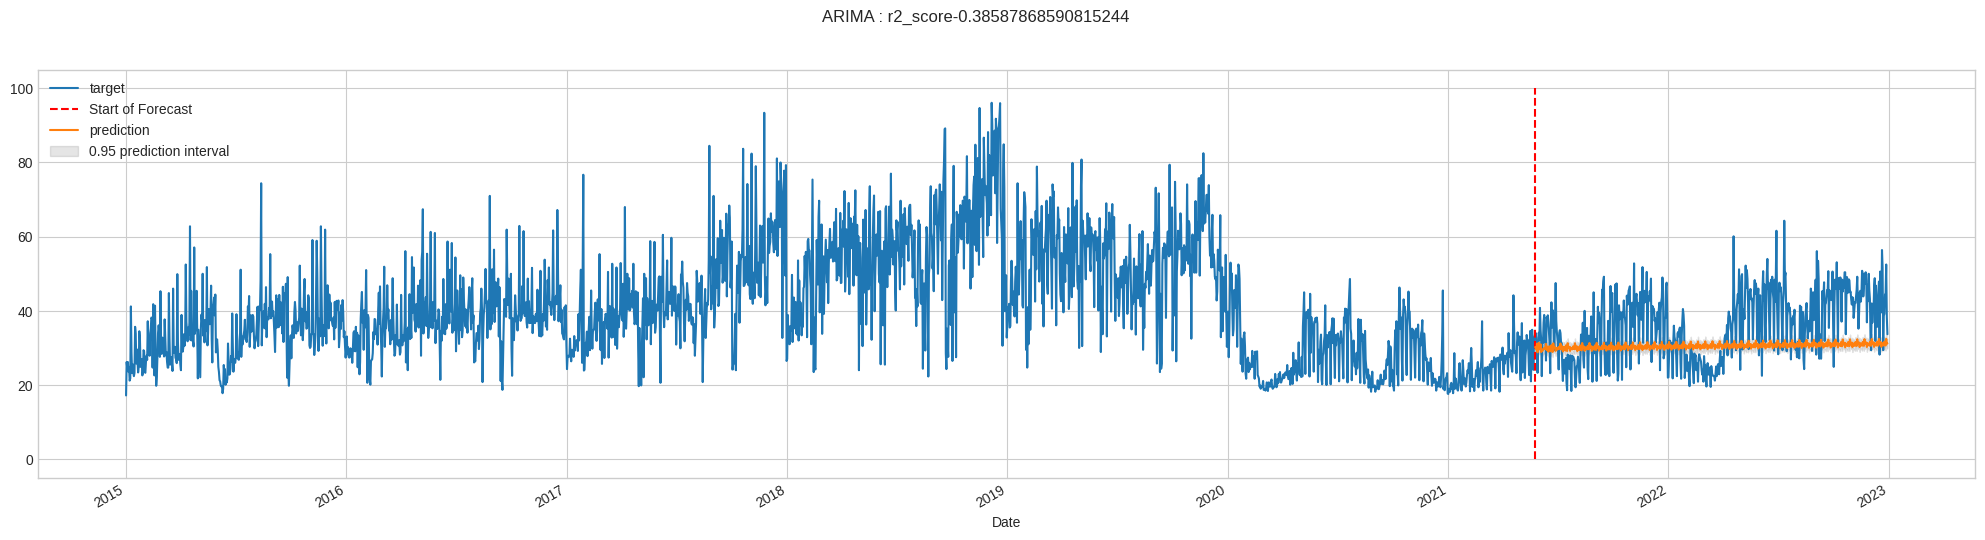

In [42]:
fig, ax = plt.subplots(figsize=(25, 6))
df.plot(ax=ax)
ax.vlines('2021-05-25', 0, 100, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predicted_value, label = 'prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA : r2_score{r2}')
plt.show()

# Auto ARIMA

In [43]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from pmdarima.arima import auto_arima

model = auto_arima(train, seasonal=True, start_p=1, start_q=1, max_p=3, max_q=3, d=1, D=1, max_P=3, max_Q=3, m=12, stepwise=True, error_action='ignore', suppress_warnings=True)


In [45]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 2339
Model:             SARIMAX(3, 1, 3)x(3, 1, [], 12)   Log Likelihood               -8598.521
Date:                             Thu, 20 Apr 2023   AIC                          17217.042
Time:                                     01:46:40   BIC                          17274.561
Sample:                                          0   HQIC                         17238.001
                                            - 2339                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2367      0.027     -8.715      0.000      -0.290      -0.183
ar.L2         -0.8838      

In [49]:
from sklearn.metrics import r2_score

# 모델 예측
prediction = model.predict(len(test), alpha=0.05)
predicted_value = prediction
predicted_ub = prediction + 1.96 * prediction.std()
predicted_lb = prediction - 1.96 * prediction.std()
predict_index = test.index
r2 = r2_score(test.values, predicted_value)


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


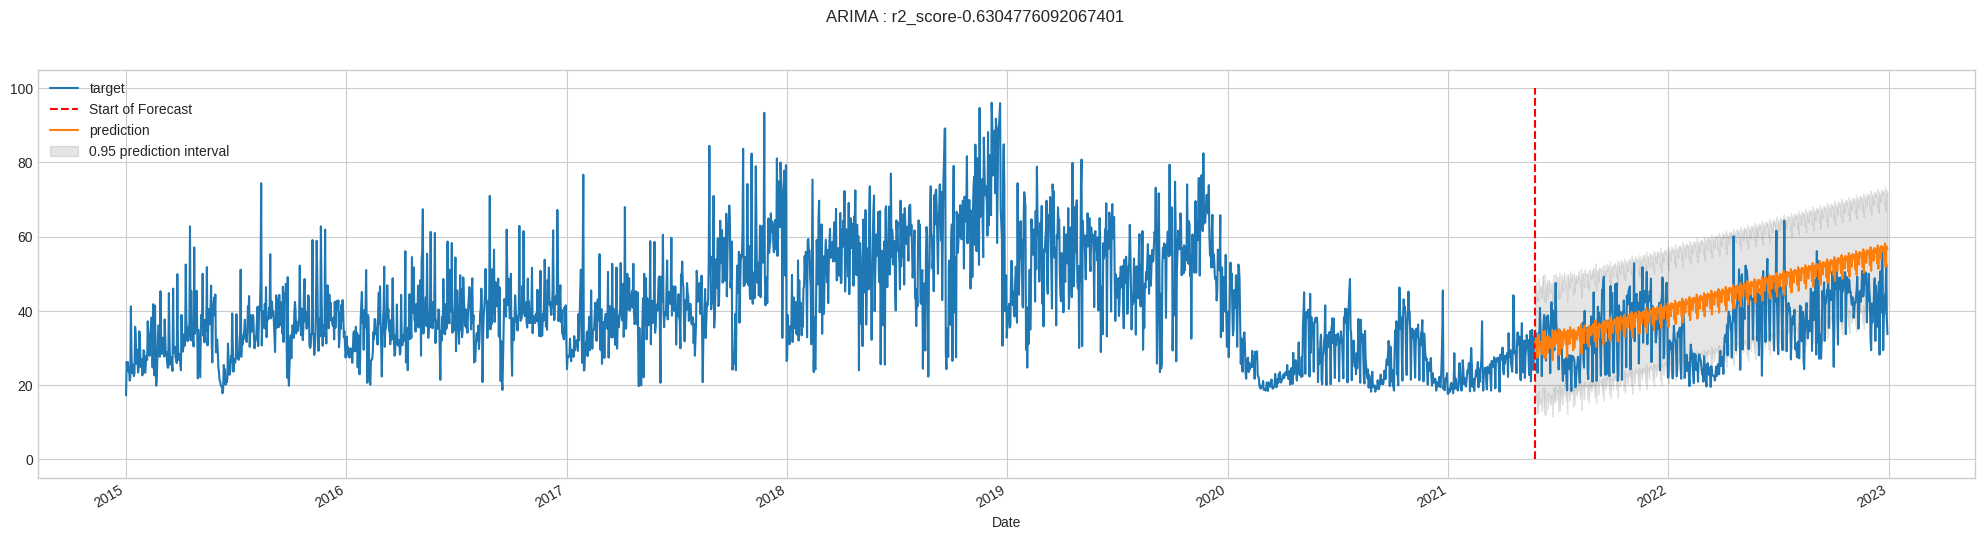

In [50]:
fig, ax = plt.subplots(figsize=(25, 6))
df.plot(ax=ax)
ax.vlines('2021-05-25', 0, 100, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predicted_value, label = 'prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA : r2_score{r2}')
plt.show()

# 주가 예측

In [52]:
data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
data

,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,AJ네트웍스,95570,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,손삼달,http://www.ajnet.co.kr,서울특별시
1,BNK금융지주,138930,기타 금융업,금융지주회사,2011-03-30,12월,빈대인,http://www.bnkfg.com,부산광역시
2,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
3,GS,78930,기타 금융업,지주회사/부동산 임대,2004-08-05,12월,"허태수, 홍순기 (각자 대표이사)",NaN,서울특별시
4,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"최익훈, 정익희, 김회언 (각자 대표이사)",http://www.hdc-dvp.com,서울특별시
...,...,...,...,...,...,...,...,...,...
2586,지앤이헬스케어,299480,기타 섬유제품 제조업,면생리대,2018-06-29,12월,장영민,http://www.hannahpad.com,경기도
2587,카이바이오텍,446600,의약품 제조업,방사성 진단 및 치료 의약품,2022-12-23,12월,김영덕,http://www.kaibiotech.com/,전라북도
2588,코스텍시스템,169670,특수 목적용 기계 제조업,"반도체 웨이퍼 이송장비, 본딩장비",2022-01-21,12월,배준호,http://www.kosteks.com/,경기도
2589,타임기술,318660,소프트웨어 개발 및 공급업,"ILS(종합군수지원), IETM(전자식기술교범), CBT(전자식교보재), 기술번역",2021-06-24,12월,주양효,http://timett.co.kr,경상남도


In [54]:
data = data[['회사명', '종목코드']]
data = data.rename(columns={'회사명':'name', '종목코드':'code'})
data.code = data.code.map('{:06d}'.format)

In [57]:
data

,name,code
0,AJ네트웍스,095570
1,BNK금융지주,138930
2,DSR,155660
3,GS,078930
4,HDC현대산업개발,294870
...,...,...
2586,지앤이헬스케어,299480
2587,카이바이오텍,446600
2588,코스텍시스템,169670
2589,타임기술,318660


In [75]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
import yfinance as yf

# 종목 코드 지정
stock_code = data[data['name']=='LG이노텍']['code']
stock_code += '.KS'
stock_code = stock_code.values[0]

# yfinance를 사용하여 데이터 가져오기
stock_data = yf.download(stock_code, start="2015-10-16", end="2020-10-14")

'''
Open : 시가
High : 고가
Low : 저가
Close : 종가
Adj Close : 주식의 분할, 배당, 배분 등을 고려해 조정한 종가
Volume : 주식 거래량
'''

# 데이터 확인
stock_data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-10-16,85300.0,86300.0,84600.0,85200.0,81713.585938,93212
2015-10-19,86000.0,86800.0,84900.0,85800.0,82289.031250,83196
2015-10-20,86000.0,86600.0,85800.0,86500.0,82960.382812,89873
2015-10-21,87200.0,96400.0,87100.0,94900.0,91016.648438,794795
2015-10-22,94700.0,97200.0,92100.0,92300.0,88523.054688,342631
...,...,...,...,...,...,...
2020-10-06,158000.0,158500.0,156500.0,157000.0,152711.125000,107303
2020-10-07,157000.0,166500.0,155000.0,166000.0,161465.265625,261275
2020-10-08,167500.0,169000.0,164000.0,166000.0,161465.265625,230506


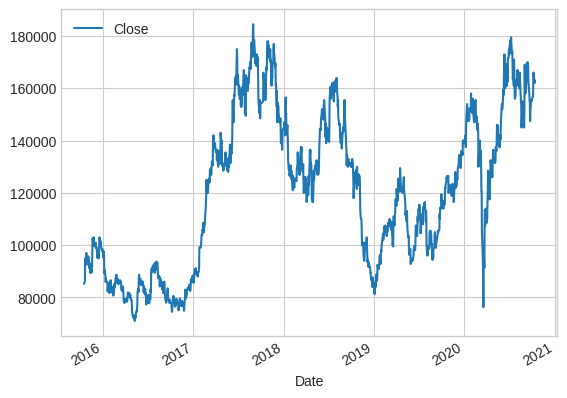

In [97]:
stock_data = stock_data[['Close']]
fig = stock_data.plot()

In [135]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(stock_data, test_size=0.05, shuffle=False)

In [136]:
train.shape, test.shape

((1161, 1), (62, 1))

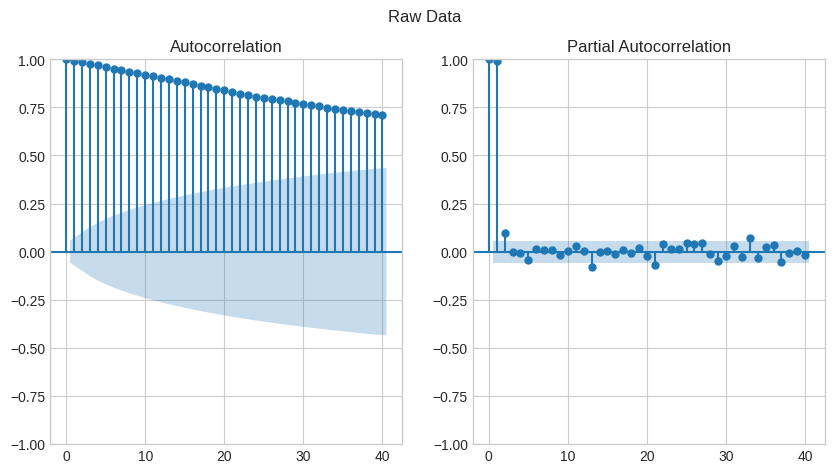

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(train.values.squeeze(), lags=40, ax=ax[1]);

* 점진적으로 낮아지기에 non-stational하다.
==> 차분 진행

In [105]:
diff_train = train.copy()
diff_train = diff_train['Close'].diff()
diff_train = diff_train.dropna()

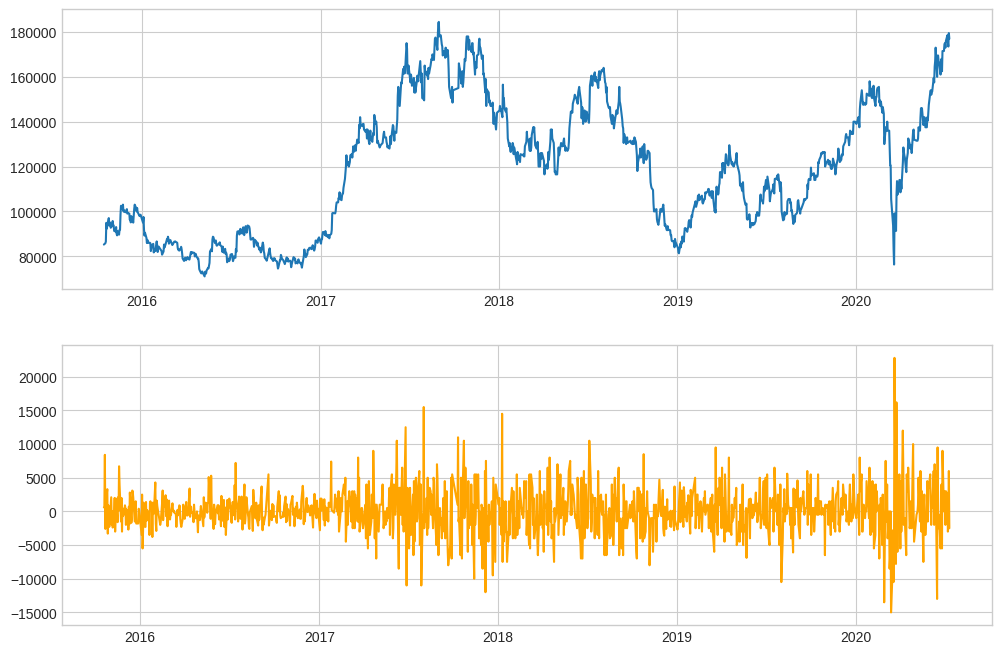

In [109]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(train['Close'])
plt.subplot(2,1,2)
plt.plot(diff_train, 'orange')

* 차분 이후 이전에 비해 stationary

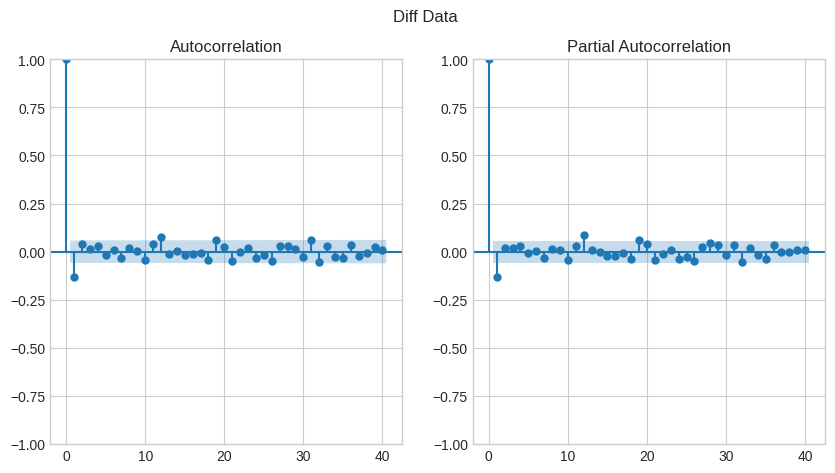

In [111]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Diff Data')
sm.graphics.tsa.plot_acf(diff_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train.values.squeeze(), lags=40, ax=ax[1]);

* 파라미터를 어떻게 선정해야 할지 감이 잘 오지 않음
==> seasonal을 한 눈에 파악하기 어렵기에, auto arima 시행 


In [113]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [137]:
from pmdarima.arima import auto_arima

auto_arima_model = auto_arima(train, start_p=1, start_q=1,
                              max_p=3, max_q=3, seasonal=False,
                              d=1,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22189.917, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22179.089, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22179.120, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=22177.926, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22178.389, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22180.151, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22179.291, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22179.815, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22179.797, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22180.345, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22180.031, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=22181.809, Time=0.51 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=22178.165, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=22179.894, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=22181.833, Time=0.45

In [138]:
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1161
Model:               SARIMAX(0, 1, 3)   Log Likelihood              -11083.963
Date:                Thu, 20 Apr 2023   AIC                          22177.926
Time:                        02:51:23   BIC                          22203.206
Sample:                             0   HQIC                         22187.465
                               - 1161                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     77.3534    100.314      0.771      0.441    -119.258     273.965
ma.L1         -0.0890      0.015     -5.917      0.000      -0.119      -0.060
ma.L2          0.0328      0.019      1.723      0.0

In [139]:
prediction = auto_arima_model.predict(len(test), return_conf_int=True)
predict_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test.index)
predict_index[0]

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Timestamp('2020-07-13 00:00:00')

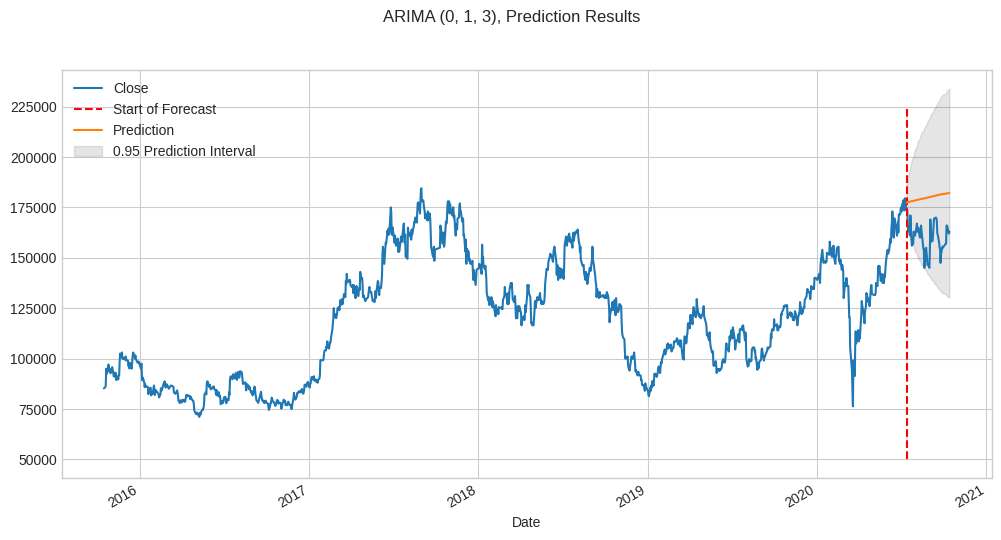

In [140]:
fig, ax = plt.subplots(figsize=(12, 6))
stock_data.plot(ax=ax)
ax.vlines('2020-07-13', 50000, 225000, linestyle='--', color='r', label='Start of Forecast')
ax.plot(predict_index, predict_value, label='Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {auto_arima_model.order}, Prediction Results')
plt.show()